/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



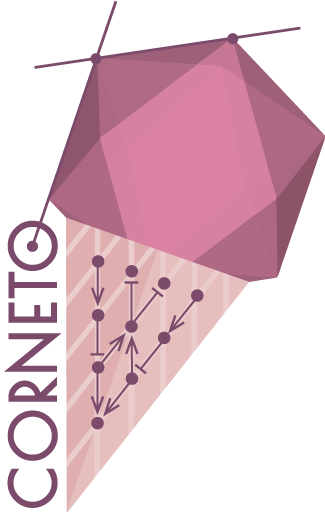

In [1]:
import os
import scanpy as sc
import pandas as pd

import liana as li
import corneto as cn
import omnipath as op
cn.info()

In [2]:
node_weights = pd.read_csv(os.path.join('results', 'myeloid_node_weights.csv'), index_col=0)['props'].to_dict()
tf_acts = pd.read_csv(os.path.join('results', 'myeloid_tf_activities.csv'))

In [3]:
target = 'Myeloid'

In [4]:
ppis = op.interactions.OmniPath().get(genesymbols = True)

ppis['mor'] = ppis['is_stimulation'].astype(int) - ppis['is_inhibition'].astype(int)
ppis = ppis[(ppis['mor'] != 0) & (ppis['curation_effort'] >= 3) & ppis['consensus_direction']]

ppis = ppis[['source_genesymbol', 'mor', 'target_genesymbol']]
ppis.columns = ['source', 'mor', 'target']

# remove other interactions to ensure the path groes through SPP1/FN1 and the correct receptor
ppis = ppis[~ppis['source'].str.contains('FN1|SPP1')]

In [5]:
# ppis.to_csv(os.path.join('results', 'ppis.csv'))

In [6]:
# source = ['FN1', 'SPP1']; target = ['ITGA5_ITGB1']; mor = [1, 1]
input_pkn = pd.concat([ppis, pd.DataFrame({'source': ['FN1', 'SPP1'], 'target': ['ITGA5_ITGB1', 'ITGA5_ITGB1'], 'mor': [1, 1]})])

In [7]:
# replace source=='ITGA5' or source=='ITGB1' with source=='ITGA5_ITGB1'
input_pkn.loc[input_pkn['source'].isin(['ITGA5', 'ITGB1']), 'source'] = 'ITGA5_ITGB1'

In [8]:
input_scores = {'FN1': 1, 'SPP1': 1}

In [9]:
output_scores = tf_acts.set_index('tf')[['activity']].to_dict()['activity']

In [10]:
output_scores

{'AP1': 3.43755,
 'E2F1': 4.3682904,
 'ELK1': 3.5032637,
 'EPAS1': 3.6555917,
 'ETS1': 3.2643123,
 'FOXO3': -3.2424684,
 'HIF1A': 3.6803513,
 'SMAD1': 3.1730103,
 'SMAD3': 4.5077853,
 'SP7': 3.9170015,
 'TCF3': 3.2572465}

In [11]:
prior_graph = li.mt.build_prior_network(input_pkn, input_scores, output_scores, verbose=True)

Importing network...
done.
 - Nodes x Edges: (4021, 8906)
 - Provided inputs included in the prior network: 2/2
 - Provided outputs included in the network: 9/11
Performing reachability analysis...
done.
 - Selected inputs: 2/2.
 - Selected outputs: 8/9.
 - Final size of the prior graph: (746, 3094).


In [12]:
# iterate over 100 seeds
dfs = {}
for i in range(100):
    print(i)
    dfs[i], _ = li.mt.find_causalnet(
                                    prior_graph,
                                    input_scores,
                                    output_scores,
                                    node_weights,
                                    node_cutoff=0.1,
                                    max_penalty=1,
                                    min_penalty=0.1,
                                    edge_penalty=0.2,
                                    verbose=False,
                                    seed=i,
                                    MIPGap=0,
                                    IntegralityFocus=1,
                                    solver='gurobi'
                                    )


0
Set parameter Username


Set parameter Username


Academic license - for non-commercial use only - expires 2025-01-26


Academic license - for non-commercial use only - expires 2025-01-26


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [13]:
res = {}
cols = ['source', 'target', 'edge_pred_val', 'target_pred_val', 'source_pred_val', 'source_type', 'target_type', 'edge_type']
for k in dfs.keys():
    df = dfs[k]
    df = df[~((df['source'].str.contains("_s|_meas|_pert").fillna(False)) | (df['target'].str.contains("_s|_meas|_pert").fillna(False)))]
    df = df[cols]
    res[k] = df.sort_values(cols)

df = pd.concat(res).drop_duplicates().sort_values(cols)


In [14]:

def count_row_occurrences(df_dict):
    # Concatenate all DataFrames into one
    combined_df = pd.concat(df_dict.values(), ignore_index=True)

    # Group by all columns and count occurrences of each unique row
    row_counts = combined_df.groupby(combined_df.columns.tolist()).size().reset_index(name='Count')
    row_counts['occurrence'] = row_counts['Count'] / len(df_dict)

    return row_counts.drop('Count', axis=1)

df = count_row_occurrences(res).sort_values(cols)

df.to_csv(os.path.join("results", f"causalpath_{target}.csv"))

df = pd.read_csv(os.path.join("results", f"causalpath_{target}.csv"), index_col=0)

df.head()


source target  edge_pred_val  target_pred_val  source_pred_val source_type  \
0   ABL1    ATR            1.0              1.0              1.0  unmeasured   
1   ABL1    RB1           -1.0             -1.0              1.0  unmeasured   
2   ABL1   YAP1            1.0              1.0              1.0  unmeasured   
3    ATM   E2F1            1.0              1.0              1.0  unmeasured   
4    ATM  HIF1A            1.0              1.0              1.0  unmeasured   

  target_type  edge_type  occurrence  
0  unmeasured          1        0.60  
1  unmeasured         -1        0.40  
2  unmeasured          1        0.24  
3      output          1        0.30  
4      output          1        0.23

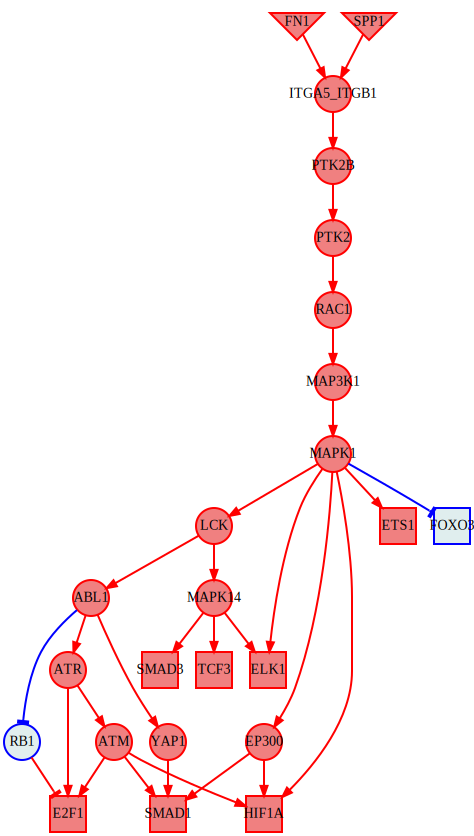

In [15]:
plot = cn.methods.carnival.visualize_network(df.dropna())
plot

In [16]:
plot.render(os.path.join('..', "figures", f"causalpath_{target}"))

'../figures/causalpath_Myeloid.pdf'

In [17]:
results = df.dropna()
# remove nodes that start with _
results = results[~ ((results['source'].str.startswith('_')) | (results['target'].str.startswith('_')))]

nodes = pd.concat([results[['source', 'source_type', 'source_pred_val']].rename(columns={'source': 'node', 'source_type': 'type', 'source_pred_val': 'sign'}),
                   results[['target', 'target_type', 'target_pred_val']].rename(columns={'target': 'node', 'target_type': 'type', 'target_pred_val': 'sign'})]).drop_duplicates().dropna()

edges = results[['source', 'target', 'edge_pred_val', 'occurrence']].dropna()

nodes.to_csv(f'results/nodes_{target}.csv')
edges.to_csv(f'results/edges_{target}.csv')